<a href="https://colab.research.google.com/github/Sendy45/NeuralNetworkFromScracth/blob/main/NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist
from tqdm.auto import tqdm

In [20]:
class NeuralNetwork:
    def __init__(self, layers_sizes, activations, initializers=[]):
        # Check for right number of layers
        if len(layers_sizes) != len(activations) + 1:
            raise Exception("Invalid number of layers")

        self.layers_sizes = layers_sizes
        self.activations = activations
        self.initializers = initializers

        if not initializers:
            self.best_initializer()

        self.weights = []
        self.biases = []
        # Create weights and biases
        for i in range(len(layers_sizes) - 1):
            in_size = layers_sizes[i]
            out_size = layers_sizes[i + 1]

            self.weights.append(self.initializer(in_size, out_size, initializers[i]))
            self.biases.append(np.zeros((out_size, 1), dtype=np.float64))

    # Activation functions and their derivatives
    @staticmethod
    def relu(z):
        return np.maximum(0, z)

    @staticmethod
    def relu_deriv(z):
        return z > 0

    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def sigmoid_deriv(z):
        sigmoid_z = NeuralNetwork.sigmoid(z)
        return sigmoid_z * (1 - sigmoid_z)

    @staticmethod
    def tanh(z):
        return np.tanh(z)

    @staticmethod
    def tanh_deriv(z):
        return 1 - np.tanh(z) ** 2

    @staticmethod
    def linear(z):
        return z

    @staticmethod
    def linear_deriv(z):
        return np.ones_like(z)

    @staticmethod
    def softmax(z):
        # numerical stability
        z = z - np.max(z, axis=0, keepdims=True)
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)

    @staticmethod
    def softmax_deriv(z, da):
        a = NeuralNetwork.softmax(z)
        # dz = a * (da - sum(da * a))
        s = np.sum(da * a, axis=0, keepdims=True)
        dz = a * (da - s)
        return dz

    # Activation functions
    # Return activation based on input and activation function selected
    def activation_function(self, z, act_type):
        if act_type == "relu":
            return NeuralNetwork.relu(z)
        elif act_type == "sigmoid":
            return NeuralNetwork.sigmoid(z)
        elif act_type == "tanh":
            return NeuralNetwork.tanh(z)
        elif act_type == "softmax":
            return NeuralNetwork.softmax(z)
        elif act_type == "linear":
            return NeuralNetwork.linear(z)
        else:
            raise Exception("Invalid activation function")

    # Activation functions derivatives
    # Return dZ based on input, dA, and activation function selected
    def activation_deriv(self, z, da, act_type):
        if act_type == "relu":
            return NeuralNetwork.relu_deriv(z) * da
        elif act_type == "sigmoid":
            return NeuralNetwork.sigmoid_deriv(z) * da
        elif act_type == "tanh":
            return NeuralNetwork.tanh_deriv(z) * da
        elif act_type == "softmax":
            # Derivative already multiply with dA
            return NeuralNetwork.softmax_deriv(z, da)
        elif act_type == "linear":
            return NeuralNetwork.linear_deriv(z) * da
        else:
            # No derivative
            return np.ones_like(z) * da

    def best_initializer(self):
        for act_type in self.activations:
            if act_type == "relu":
                self.initializers.append("he")
            elif act_type in ["sigmoid", "tanh", "softmax", "linear"]:
                self.initializers.append("xavier")
            else:
                raise Exception("Invalid activation function")


    def initializer(self, in_size, out_size, init_type):

        if init_type == "he":
            # W ~ N(0, √(2/in))
            std = np.sqrt(2.0 / in_size)
            W = np.random.randn(out_size, in_size) * std

        elif init_type == "xavier":
            # U(-√(6/(in+out)),√(6/(in+out)))
            limit = np.sqrt(6.0 / (in_size + out_size))
            W = np.random.uniform(-limit, limit, (out_size, in_size))

        else:
            W = np.random.randn(out_size, in_size) * 0.01

        return W.astype(np.float64)



    # One hot encoding for y_true - convert format into a matrix for calculations
    @staticmethod
    def one_hot_encoding(y):
        one_hot_y = np.zeros((y.size, y.max() + 1))
        one_hot_y[np.arange(y.size), y] = 1
        one_hot_y = one_hot_y.T
        return one_hot_y

    # Forward function - feed input and get prediction
    def forward(self, x):
        # Z = W * A + B
        # A - output (after activation function)
        # Also next layer input
        z_lst = []
        a_lst = []

        a_lst.append(x) # acts as A0

        # Goes through the entire network
        for i in range(len(self.weights)):
            z = np.dot(self.weights[i], a_lst[i]) + self.biases[i]
            z_lst.append(z)
            # Activation
            a = self.activation_function(z, self.activations[i])
            a_lst.append(a)

        return z_lst, a_lst

    # Backwatd function - locates the origin of the loss and tweaks it
    def backward(self, z_lst, a_lst, x, y_true, loss_function):

      # Size - for relative, pair batch ratio
      m = y_true.size
      # Delta of weights and biases
      # The amount of change each weight and bias gets change by
      dw_lst = [np.zeros_like(w, dtype=np.float64) for w in self.weights]
      db_lst = [np.zeros_like(b, dtype=np.float64) for b in self.biases]

      # Start with the last layer
      dz = None
      L = len(self.weights)

      # Backpropagation: iterate layers in reverse order (from last to first)
      # Compute gradients dW and dB for each layer
      for i in reversed(range(L)):

          if i == L - 1:
              # Output layer:
              # dA = ∂J/∂A_L
              # This is the derivative of the loss w.r.t. the network output
              da = self.loss_derivative(a_lst[i + 1], y_true, loss_function)
          else:
              # Hidden layers:
              # dA = W_{i+1}^T · dZ_{i+1}
              # Propagate the gradient from the next layer back to this layer
              da = self.weights[i + 1].T.dot(dz)

          # dZ_i = dA_i ⊙ f'(Z_i)
          # Apply derivative of activation function element-wise
          dz = self.activation_deriv(z_lst[i], da, self.activations[i])

          # dW_i = (1/m) · dZ_i · A_{i}^T
          # Gradient of the loss w.r.t. weights of layer i
          dw_lst[i] = (1 / m) * dz.dot(a_lst[i].T)

          # dB_i = (1/m) · sum(dZ_i) over the batch
          # Gradient of the loss w.r.t. biases of layer i
          db_lst[i] = (1 / m) * np.sum(dz, axis=1, keepdims=True)

      # Return gradients for all layers
      return dw_lst, db_lst

    # Loss derivative - for the last layer based on the loss-type
    def loss_derivative(self, y_pred, y_true, loss_type):
        one_hot = NeuralNetwork.one_hot_encoding(y_true) # y_true formatting
        eps = 1e-9 # Avoid dividing by zero

        # Division by m happens in backward function
        if loss_type == "cross_entropy":
            # - y_true / y_pred
            return -(one_hot / (y_pred + eps))

        elif loss_type == "mse":
            # 2 * (y_pred - y_true)
            return 2 * (y_pred - one_hot)

        else:
            raise Exception("Invalid loss function")

    # Compute loss for logging
    @staticmethod
    def compute_loss(self, y_pred, y_true, loss_type, lambda_=0.0):
        one_hot = NeuralNetwork.one_hot_encoding(y_true)  # shape: (num_classes, N)
        m = y_true.size

        if loss_type == "cross_entropy":
          eps = 1e-9 # Avoid dividing by zero
          # -1/m * ∑ (y_true * log(y_pred))
          data_loss = -np.sum(one_hot * np.log(y_pred + eps)) / m
        elif loss_type == "mse":
          # 1/m * ∑ ((y_pred - y_true)^2)
          data_loss = np.mean((y_pred - one_hot) ** 2)
        else:
          raise Exception("Invalid loss function")

        # L2 regularization term: (λ / 2m) * sum(||W||^2)
        reg_loss = 0.0
        for W in self.weights:
            reg_loss += np.sum(W ** 2)

        reg_loss = (lambda_ / (2 * m)) * reg_loss

        return data_loss + reg_loss


    # Update weights and biases
    # Uses dW and dB from backward function
    # lr = learning rate
    # high lr - impact the model fast, can overshoot
    # low lr - learns slower, wont overshoot
    # Lambda λ = Counter overfitting by punishing big weights
    # Force weights to be small but not zero (w = 0 -> no impact on the model)
    def update(self, dw_lst, db_lst, lr, lambda_):
      for i in range(len(self.weights)):
        # W = W - lr * (dW + λ * W)
        self.weights[i] -= lr * (dw_lst[i] + lambda_ * self.weights[i])
        self.biases[i] -= lr * db_lst[i]

    # Return the most activated output neuron
    @staticmethod
    def predict(x):
      return np.argmax(x,0)

    # Calculte model accuracy
    @staticmethod
    def accuracy(predictions, y):
      return np.sum(predictions==y) / y.size

    # Compile the model and trains it
    # x - input features
    # y - labels
    # lr - learning rate
    # epochs - num of iterations over the data
    # batch_size - data size before model updating
    # loss_type - loss functions used
    # lambda_ - lambda used for preventing weights overfitting
    def gradient_descent(self, x, y, lr=0.1, epochs=10, batch_size=1, loss_type="cross_entropy", lambda_=.0):
      for ep in range(epochs):
        predictions = np.array([])
        epoch_loss = 0

        # Batches
        # tqdm - loading animation
        for i in tqdm(range(0, x.shape[1], batch_size)):
          # get batch
          x_batch = x[:, i:i+batch_size]
          y_batch = y[i:i+batch_size]
          # feed model
          z_lst, a_lst = self.forward(x_batch)

          dw_lst, db_lst = self.backward(z_lst, a_lst, x_batch, y_batch, loss_function=loss_type)

          self.update(dw_lst, db_lst, lr, lambda_)

          # Monitor loss - epoch_loss = Avg(batches_loss)
          predictions = np.concatenate((predictions, NeuralNetwork.predict(a_lst[-1])))
          batch_loss = NeuralNetwork.compute_loss(self, a_lst[-1], y_batch, loss_type=loss_type, lambda_=lambda_)
          epoch_loss += batch_loss / (x.shape[1] / batch_size)

        print("Epoch: ", ep)
        print("Accuracy: ", NeuralNetwork.accuracy(predictions, y))
        print("Loss: ", epoch_loss)

In [21]:
nn = NeuralNetwork([784, 64, 10], ["relu","softmax"])

In [22]:
# Load the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()

train_X = train_X.reshape(60000, 784).astype('float32') / 255.0
test_X  = test_X.reshape(10000, 784).astype('float32') / 255.0


In [23]:
train_X = train_X.T   # shape: (784, 60000)
test_X  = test_X.T    # shape: (784, 10000)

In [24]:
nn.gradient_descent(train_X, train_y, 0.1, 10, 64, "cross_entropy", 0.001)

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:  0
Accuracy:  0.8931666666666667
Loss:  0.3914627211246611


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:  1
Accuracy:  0.9391666666666667
Loss:  0.21881801234187587


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:  2
Accuracy:  0.95155
Loss:  0.17654308484533662


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:  3
Accuracy:  0.9584333333333334
Loss:  0.15216124066579462


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:  4
Accuracy:  0.96335
Loss:  0.13580483048002726


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:  5
Accuracy:  0.9673666666666667
Loss:  0.12401603841025499


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:  6
Accuracy:  0.9699333333333333
Loss:  0.11528281769624264


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:  7
Accuracy:  0.9720666666666666
Loss:  0.10843154597556608


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:  8
Accuracy:  0.9736333333333334
Loss:  0.10300997635098193


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch:  9
Accuracy:  0.9748166666666667
Loss:  0.09866995747235402


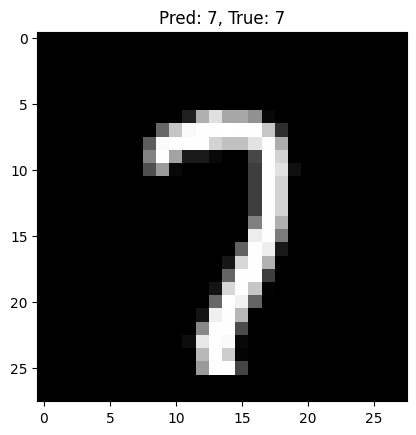

In [32]:
idx = np.random.randint(test_X.shape[1])   # random sample index

x = test_X[:, idx:idx+1]    # shape (784, 1)
y_true = test_y[idx]

_, a_lst = nn.forward(x)
y_pred = NeuralNetwork.predict(a_lst[-1])[0]

plt.imshow(x.reshape(28,28), cmap="gray")
plt.title(f"Pred: {y_pred}, True: {y_true}")
plt.show()